In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ensure src is in path
sys.path.append('..')

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

DATA_DIR = Path("../data/processed")

In [3]:
from src.vol import compute_ewma_vol, compute_garch_vol

In [4]:
RET_PATH     = DATA_DIR / "continuous_returns.parquet"          # cleaned front returns
SIGNAL_PATH  = DATA_DIR / "master_dataset_with_signals.parquet" # tsmom + carry_z

# Data Load

In [5]:
# 1) load returns (date x root)
rets = pd.read_parquet(RET_PATH)          # index: date, cols: roots
rets = rets.sort_index()

# 2) load signals + meta (long format)
df_sig = pd.read_parquet(SIGNAL_PATH)
df_sig["date"] = pd.to_datetime(df_sig["date"])
df_sig = df_sig.sort_values(["date", "root"])

In [6]:
print(rets.shape, df_sig.shape)

(3111, 28) (606566, 25)


In [7]:
trim_start = "2016-01-01"

# Trim returns panel
rets_trim = rets.loc[trim_start:].copy()

# Trim signal dataframe (long format)
df_sig_trim = df_sig[(df_sig["date"] >= trim_start)].copy()

print(rets_trim.index.min(), rets_trim.index.max())
print(df_sig_trim["date"].min(), df_sig_trim["date"].max())

2016-01-03 00:00:00 2024-12-31 00:00:00
2016-01-03 00:00:00 2024-12-31 00:00:00


In [8]:
# drop RTY
rets_trim = rets_trim.drop(columns=["RTY"], errors="ignore")
df_sig_trim = df_sig_trim[df_sig_trim["root"] != "RTY"].copy()

In [9]:
df_sig_trim = df_sig_trim[
    df_sig_trim.groupby("instrument_id")["date"].transform("rank") > 1
].copy()

In [10]:
df_sig_trim.isna().sum()

date                  0
root                  0
raw_symbol            0
expiration            0
open                  0
high                  0
low                   0
close                 0
volume                0
currency              0
instrument_id         0
month_code            0
year_code             0
parent                0
asset_class           0
region                0
days_to_expiry        0
is_front              0
is_next               0
return                0
carry             20422
tsmom_3m              0
tsmom_6m              0
tsmom_12m             0
carry_z           21735
dtype: int64

In [11]:
df_sig_trim.isna().sum()

date                  0
root                  0
raw_symbol            0
expiration            0
open                  0
high                  0
low                   0
close                 0
volume                0
currency              0
instrument_id         0
month_code            0
year_code             0
parent                0
asset_class           0
region                0
days_to_expiry        0
is_front              0
is_next               0
return                0
carry             20422
tsmom_3m              0
tsmom_6m              0
tsmom_12m             0
carry_z           21735
dtype: int64

# Compute EWMA Volatility Estimates

In [23]:
lambda_daily = 0.94 #industry standard daily decay used in RiskMetrics
ewma_vol = compute_ewma_vol(rets_trim, lambda_=lambda_daily)

In [24]:
print(ewma_vol.shape)

(2799, 27)


In [25]:
(ewma_vol.tail())

root,6A,6B,6C,6E,6J,6N,6S,CL,ES,GC,...,UB,ZB,ZC,ZF,ZL,ZM,ZN,ZS,ZT,ZW
date,,,,,,,,,,,,,,,,,,,,,
2024-12-26,0.095258,0.065884,0.058429,0.064491,0.081825,0.103450,0.068627,0.190637,0.079413,0.135236,...,0.120939,0.079290,0.136887,0.027384,0.257193,0.280857,0.043998,0.148676,0.008210,0.162256
2024-12-27,0.092712,0.065886,0.057046,0.062544,0.079361,0.100432,0.068110,0.187740,0.087679,0.133572,...,0.120921,0.080381,0.132717,0.026809,0.249637,0.277020,0.043704,0.146577,0.007960,0.162637
2024-12-29,0.090045,0.063878,0.055394,0.060680,0.076982,0.097461,0.066035,0.182293,0.085057,0.129544,...,0.117309,0.077962,0.128800,0.025993,0.242232,0.268585,0.042373,0.142174,0.007719,0.158905
2024-12-30,0.087337,0.062578,0.057681,0.059749,0.078281,0.094492,0.064438,0.181779,0.094500,0.127347,...,0.122397,0.085909,0.125170,0.029276,0.235018,0.261435,0.047075,0.138018,0.009360,0.154320
2024-12-31,0.087458,0.061634,0.056174,0.060808,0.076520,0.096829,0.065148,0.179888,0.092143,0.125977,...,0.122272,0.085231,0.131845,0.028590,0.227867,0.259954,0.046504,0.147619,0.009076,0.150466


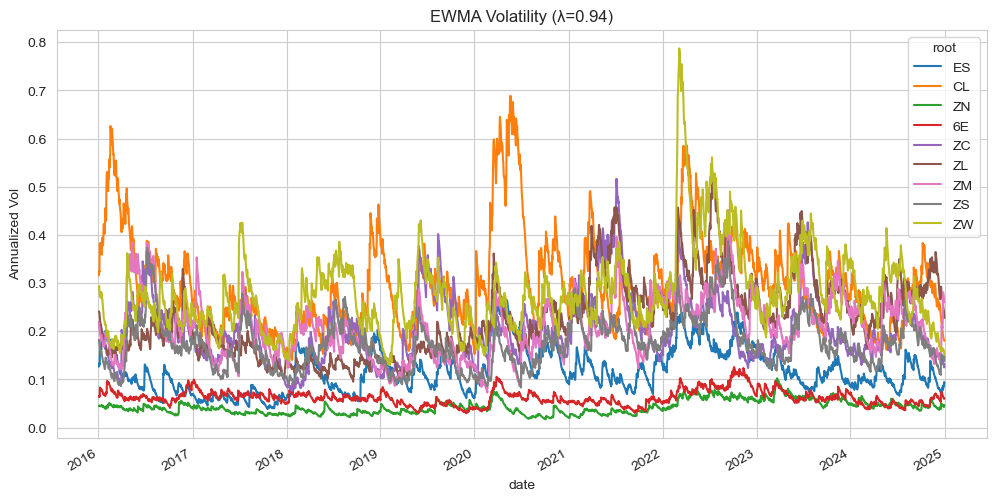

In [26]:
sample = ["ES", "CL", "ZN", "6E", 'ZC', 'ZL', 'ZM', 'ZS', 'ZW']
ewma_vol[sample].plot(title="EWMA Volatility (λ=0.94)")
plt.ylabel("Annualized Vol")
plt.show()

# Compute GARCH(1,1) Volatility Estimates

In [27]:
garch_vol = compute_garch_vol(rets_trim, omega=1e-6, alpha=0.05, beta=0.90)

<Figure size 1200x600 with 0 Axes>

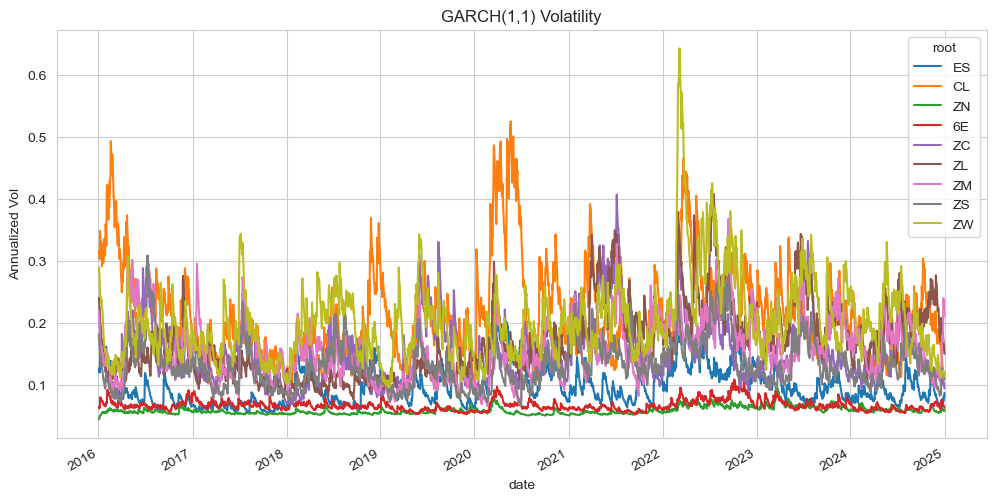

In [30]:
sample = ["ES", "CL", "ZN", "6E", 'ZC', 'ZL', 'ZM', 'ZS', 'ZW']

plt.figure(figsize=(12,6))
garch_vol[sample].plot(title="GARCH(1,1) Volatility")
plt.ylabel("Annualized Vol")
plt.show()

# save data

In [33]:
outdir = "../data/processed/"
os.makedirs(outdir, exist_ok=True)

In [34]:
rets_trim.to_parquet(outdir + "continuous_returns_upd.parquet")
df_sig_trim.to_parquet(outdir + "master_dataset_with_signals_upd.parquet")
ewma_vol.to_parquet(outdir + "ewma_vol.parquet")
garch_vol.to_parquet(outdir + "garch_vol.parquet")